# Plot proteobacteria in Patient 006 over time

In [1]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import scipy.spatial.distance as dist, itertools
import skbio.diversity as div, scipy.stats as stats, skbio.stats.ordination as ordination
from io import StringIO
from skbio import TreeNode
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

In [2]:
def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

In [3]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

In [4]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})
md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [5]:
#read in 16S data
otu_ftab = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f.tsv',
                       sep='\t', index_col=0).astype(int)
otu_rare = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f_rare8500.tsv',
                       sep='\t', index_col=0).astype(int)

#read in taxa
taxa = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/taxonomy.tsv',
                   sep='\t')
taxa[['domain', 'phylum', 'class',
      'order', 'family', 'genus',
      'species']] = taxa['Taxon'].str.split(';', expand=True)
taxa = taxa.rename(columns={'Feature ID': '#OTU ID'})

In [6]:
#read in meatgenomics
mtphl = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/metaphlan/deepdive_metaphlan_tax_abun.tsv.gz',
                    sep='\t', index_col=0)
#add taxa level
mtphl.loc[:, 'taxa_level'] = mtphl.index.str.count('\|') + 1

In [20]:
#make a tidy dataframes
otu_tidy = otu_ftab.reset_index().melt(id_vars='#OTU ID', 
                                       var_name='sample_id',
                                       value_name='count')
#otu_tidy = otu_tidy.loc[otu_tidy['count'] > 0]
#add relative abundance
otu_tidy = relative_abundance_tidy(otu_tidy, 'sample_id', 'count')
#add metadata
otu_tidy = otu_tidy.merge(md)
#add taxa
otu_tidy_taxa = otu_tidy.merge(taxa)

#get mgx
mtphl_md = mtphl.reset_index().rename(columns={'sample': 
                                               'sample_id'}).merge(md)
#get only species
mtphl_md_sp = mtphl_md.loc[mtphl_md['taxa_level'] == 7]

In [21]:
#list donor samples
sam_0044 = md.loc[md['patient'] == '0044']['sample_id'].tolist()
sam_0073 = md.loc[md['patient'] == '0073']['sample_id'].tolist()

#get donor otus
otu_0044 = set(otu_ftab[sam_0044].loc[otu_ftab[sam_0044].astype(bool).any(axis=1)].index)
otu_0073 = set(otu_ftab[sam_0073].loc[otu_ftab[sam_0073].astype(bool).any(axis=1)].index)

donor_otus_dict = {'0044': otu_0044, '0073': otu_0073}

#get donor species
sp_0044 = set(mtphl_md_sp.loc[mtphl_md_sp['sample_id'].isin(sam_0044)]['taxa'])
sp_0073 = set(mtphl_md_sp.loc[mtphl_md_sp['sample_id'].isin(sam_0073)]['taxa'])

donor_sp_dict = {'0044': sp_0044, '0073': sp_0073}

In [22]:
otu_tidy_taxa['phylum'].unique()

array(['D_1__Bacteroidetes', 'D_1__Firmicutes', 'D_1__Actinobacteria',
       'D_1__Proteobacteria', 'D_1__Verrucomicrobia', 'D_1__Tenericutes',
       'D_1__Fusobacteria', 'D_1__Cyanobacteria',
       'D_1__Epsilonbacteraeota', None, 'D_1__Lentisphaerae'],
      dtype=object)

In [23]:
#get df for plotting
plt_df = otu_tidy_taxa.loc[(otu_tidy_taxa['patient'] == '006') & \
                           (otu_tidy_taxa['phylum'] == 'D_1__Proteobacteria')]

#get cumlative abundance of proteos
cabun = plt_df.groupby(['sample_id', 'days_past_fmt'])['rel_abun'].sum()
cabun = cabun.rename('cabun_proteo').reset_index()

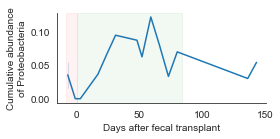

In [30]:
fig = plt.figure(figsize = (4,2))

ax = sns.lineplot(x='days_past_fmt', y='cabun_proteo',
                  data=cabun)
ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.05, color='green') #capsules

ax.set_xlabel('Days after fecal transplant')
ax.set_ylabel('Cumulative abundance\nof Proteobacteria')

sns.despine()
plt.tight_layout()
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pat006_proteo_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pat006_proteo_2019-05-05.pdf',
            dpi=300)

In [ ]:
otu_tidy